In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

In [3]:
from queue import Queue
openPMDBuffer = Queue(8)

In [4]:
from ks_producer_openPMD_streaming import StreamLoader
from ks_transform_policies import AbsoluteSquare, BoxesAttributesParticles

normalization_values = dict(
    momentum_mean = 1.2091940752668797e-08,
    momentum_std = 0.11923234769525472,
    force_mean = -2.7682006649827533e-09,
    force_std = 7.705477610810592e-05
)


streamLoader_config = dict(
    t0 = 900,
    t1 = 998,
    # t0 =  1800,
    # t1 = 1810,
    streaming_config = None,
    #pathpattern1 = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/24-nodes_full-picongpu-data/simOutput/openPMD/simData_%T.bp", # files on hemera
    #pathpattern2 = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/24-nodes_full-picongpu-data/simOutput/radiationOpenPMD/e_radAmplitudes%T.bp", # files on hemera
    #pathpattern1 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/014_KHI_007_noWindowFunction/simOutput/openPMD/simData_%T.bp", # files on hemera
    #pathpattern2 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/014_KHI_007_noWindowFunction/simOutput/radiationOpenPMD/e_radAmplitudes%T.bp", # files on hemera
    #pathpattern1 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/015_KHI_009_noWindowFunction/simOutput/openPMD/simData_%T.bp", # files on hemera
    #pathpattern2 = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/015_KHI_009_noWindowFunction/simOutput/radiationOpenPMD/e_radAmplitudes%T.bp", # files on hemera
    pathpattern1 = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/24-nodes_full-picongpu-data/04-01_1013/simOutput/openPMD/simData_%T.bp5",
    pathpattern2 = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/24-nodes_full-picongpu-data/04-01_1013/simOutput/radiationOpenPMD/e_radAmplitudes_%T.bp5",
    
    amplitude_direction=0, # choose single direction along which the radiation signal is observed, max: N_observer-1, where N_observer is defined in PIConGPU's radiation plugin
    phase_space_variables = ["momentum", "force"], # allowed are "position", "momentum", and "force". If "force" is set, "momentum" needs to be set too.
    number_particles_per_gpu = 30000,
    verbose=False,
    ## offline training params
    num_epochs = .01, #.0625
    normalization = normalization_values
)

timeBatchLoader = StreamLoader(openPMDBuffer, 
                                        streamLoader_config,
                                        BoxesAttributesParticles(), AbsoluteSquare())

timeBatchLoader.start()

>>>>> StreamLoader: Series defined.


In [5]:
openPMDBuffer.qsize()

0

In [6]:
data = []
for i in range(0, 100, 10):
    data.append(openPMDBuffer.get())

>>>>> StreamLoader: Series parsed.
Skipping iteration 895 as it is not in the specified range [t0,t1)=[900,998)


[WARNING] No chunk table found in data. Will map source to sink ranks somehow, but this might scale terribly in streaming setups.
[Series] Use rank table in file-based iteration encoding at your own risk. Make sure to have an iteration open before calling this.


Skipping iteration 896 as it is not in the specified range [t0,t1)=[900,998)
Skipping iteration 897 as it is not in the specified range [t0,t1)=[900,998)
Skipping iteration 898 as it is not in the specified range [t0,t1)=[900,998)
Skipping iteration 899 as it is not in the specified range [t0,t1)=[900,998)
Start processing iteration 900
particles per GPU 30000
Done loading iteration 900
Start processing iteration 901
particles per GPU 30000
Done loading iteration 901
Start processing iteration 902
particles per GPU 30000
Done loading iteration 902
Start processing iteration 903
particles per GPU 30000
Done loading iteration 903
Start processing iteration 904
particles per GPU 30000
Done loading iteration 904
Start processing iteration 905
particles per GPU 30000
Done loading iteration 905
Start processing iteration 906
particles per GPU 30000
Done loading iteration 906
Start processing iteration 907
particles per GPU 30000
Done loading iteration 907
Start processing iteration 908
parti

In [13]:
import model_config
import io_config_hemera as io_config

config = model_config.config

import torch.nn as nn
from torch import optim

from ks_models import INNModel

from utilities import MMD_multiscale, fit, load_checkpoint
from train_khi_AE_refactored.args_transform import MAPPING_TO_LOSS
from train_khi_AE_refactored.encoder_decoder import Encoder
from train_khi_AE_refactored.encoder_decoder import Encoder
from train_khi_AE_refactored.encoder_decoder import Conv3DDecoder, MLPDecoder
from train_khi_AE_refactored.loss_functions import EarthMoversLoss
from train_khi_AE_refactored.networks import VAE, ConvAutoencoder

world_size = 1

class ModelFinal(nn.Module):
    def __init__(self,
                base_network,
                inner_model,
                loss_function_IM = None,
                weight_AE=1.0,
                weight_IM=1.0):
        super().__init__()

        self.base_network = base_network
        self.inner_model = inner_model
        self.loss_function_IM = loss_function_IM
        self.weight_AE = weight_AE
        self.weight_IM = weight_IM

    def forward(self, x, y):

        loss_AE,loss_ae_reconst,kl_loss, _, encoded = self.base_network(x)

        # Check if the inner model is an instance of INNModel
        if isinstance(self.inner_model, INNModel):
            # Use the compute_losses function of INNModel
            loss_IM, l_fit,l_latent,l_rev = self.inner_model.compute_losses(encoded, y)
            total_loss = loss_AE*self.weight_AE + loss_IM*self.weight_IM

            losses = {
                'total_loss': total_loss,
                'loss_AE': loss_AE*self.weight_AE,
                'loss_IM': loss_IM*self.weight_IM,
                'loss_ae_reconst': loss_ae_reconst,
                'kl_loss': kl_loss,
                'l_fit': l_fit,
                'l_latent': l_latent,
                'l_rev': l_rev,
                    }

            return losses
        else:
            # For other types of models, such as MAF
            loss_IM = self.inner_model(inputs=encoded, context=y)
            total_loss = loss_AE*self.weight_AE + loss_IM * self.weight_IM

            losses = {
                'total_loss': total_loss,
                'loss_AE': loss_AE*self.weight_AE,
                'loss_IM': loss_IM*self.weight_IM,
                'loss_ae_reconst': loss_ae_reconst,
                'kl_loss': kl_loss
                    }

            return losses

    def reconstruct(self,x, y, num_samples = 1):

        if isinstance(self.inner_model, INNModel):
            lat_z_pred = self.inner_model(x, y, rev = True)
            y = self.base_network.decoder(lat_z_pred)
        else:
            lat_z_pred = self.inner_model.sample_pointcloud(num_samples = num_samples, cond=y)
            y = self.base_network.decoder(lat_z_pred)

        return y, lat_z_pred


VAE_encoder_kwargs = {"ae_config":"non_deterministic",
                "z_dim":model_config.latent_space_dims,
                "input_dim":io_config.ps_dims,
                "conv_layer_config":[16, 32, 64, 128, 256, 608],
                "conv_add_bn": False,
                "fc_layer_config":[544]}

VAE_decoder_kwargs = {"z_dim":model_config.latent_space_dims,
                "input_dim":io_config.ps_dims,
                "initial_conv3d_size":[16, 4, 4, 4],
                "add_batch_normalisation":False,
                    "fc_layer_config":[1024]}
def load_objects(rank):

    torch.cuda.set_device(rank)
    torch.cuda.empty_cache()

    loss_fn_for_VAE = MAPPING_TO_LOSS[model_config.config['loss_function']](**model_config.config['loss_kwargs'])

    VAE_obj = VAE(encoder = Encoder,
            encoder_kwargs = VAE_encoder_kwargs,
            decoder = Conv3DDecoder,
            z_dim=model_config.latent_space_dims,
            decoder_kwargs = VAE_decoder_kwargs,
            loss_function = loss_fn_for_VAE,
            property_="momentum_force",
            particles_to_sample = io_config.number_of_particles,
            ae_config="non_deterministic",
            use_encoding_in_decoder=False,
            weight_kl=model_config.config["lambd_kl"],
            device=rank)

    # conv_AE
#     conv_AE_encoder_kwargs = {"ae_config":"simple",
#                     "z_dim":model_config.latent_space_dims,
#                     "input_dim":io_config.ps_dims,
#                     "conv_layer_config":[16, 32, 64, 128, 256, 512],
#                     "conv_add_bn": False}

#     conv_AE_decoder_kwargs = {"z_dim":model_config.latent_space_dims,
#                     "input_dim":io_config.ps_dims,
#                     "add_batch_normalisation":False}

#     conv_AE = ConvAutoencoder(encoder = Encoder,
#                             encoder_kwargs = conv_AE_encoder_kwargs,
#                             decoder = Conv3DDecoder,
#                             decoder_kwargs = conv_AE_decoder_kwargs,
#                             loss_function = EarthMoversLoss(),
#                             )

    # MAF inner model (not used in final runs)
    # inner_model = PC_MAF(dim_condition=config["dim_condition"],
    #                         dim_input=config["dim_input"],
    #                         num_coupling_layers=config["num_coupling_layers"],
    #                         hidden_size=config["hidden_size"],
    #                         device=rank,
    #                         num_blocks_mat = config["num_blocks_mat"],
    #                         activation = config["activation"]
    #                         )

    # INN
    inner_model = INNModel(ndim_tot=config["ndim_tot"],
                    ndim_x=config["ndim_x"],
                    ndim_y=config["ndim_y"],
                    ndim_z=config["ndim_z"],
                    loss_fit=fit,
                    loss_latent=MMD_multiscale,
                    loss_backward=MMD_multiscale,
                    lambd_predict=config["lambd_predict"],
                    lambd_latent=config["lambd_latent"],
                    lambd_rev=config["lambd_rev"],
                    zeros_noise_scale=config["zeros_noise_scale"],
                    y_noise_scale=config["y_noise_scale"],
                    hidden_size=config["hidden_size"],
                    activation=config["activation"],
                    num_coupling_layers=config["num_coupling_layers"],
                    device = rank)

    #model = ModelFinal(VAE_obj, inner_model, EarthMoversLoss())
    #model = ModelFinal(conv_AE, inner_model, EarthMoversLoss())
    model = ModelFinal(VAE_obj,
                       inner_model,
                       EarthMoversLoss(),
                       weight_AE=config["lambd_AE"],
                       weight_IM=config["lambd_IM"])


    #Load a pre-trained model
    # filepath = '/autofs/nccs-svm1_home1/ksteinig/src/InSituML/main/ModelHelpers/cINN/trained_models/{}/best_model_'
    # filepath = 'trained_models/{}/best_model_'
    filepath = io_config.modelPathPattern

    #map_location = {'cuda:%d' % 0: 'cuda:%d' % rank}
    
    # updated_state_dict = {key.replace('VAE.', 'base_network.'): value for key, value in original_state_dict.items()}
    updated_state_dict = {key.replace('module.', ''): value for key, value in ckpt["model"].items()}
    model.load_state_dict(updated_state_dict)

    lr = config["lr"]
    bs_factor = io_config.trainBatchBuffer_config["training_bs"] / 2 * world_size
    lr = lr * config["lr_scaling"](bs_factor)
    print("Skaling learning rate from {} to {} due to bs factor {}".format(config["lr"], lr, bs_factor))
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=config["betas"],
                         eps=config["eps"], weight_decay=config["weight_decay"])
    if ( "lr_annealingRate" not in config ) or config["lr_annealingRate"] is None:
        scheduler = None
    else:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=config["lr_annealingRate"])

    return optimizer, scheduler, model



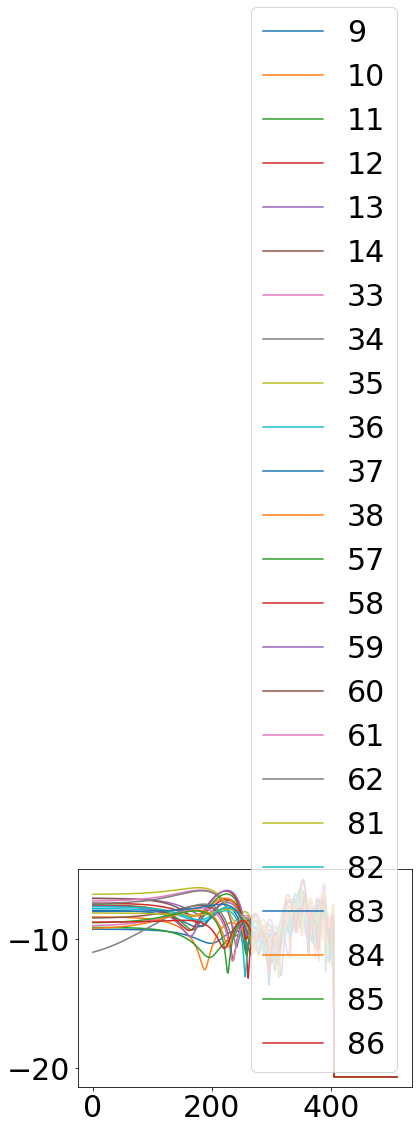

In [20]:
boxlist = []
for i in range(90):
    if data[5][1][i][410] < -15:
        plt.plot(data[5][1][i], label=str(i))
        boxlist.append(i)
plt.legend()
#plt.xlim(400,430)

In [21]:
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921762/model_8081"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921753/model_809"
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs_y/slurm-6921781/model_19000"
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs_y/slurm-6921781/model_19000"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6921842/model_8081"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/trained_models/inn_vae_latent_544_sim014_859eopan/model_950"
#ckptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/runs014_30k/slurm-{}/model_{}"
#ckptfn = chkptfn.format(6921756, 809) # 950, contniue at 150k
#ckptfn = chkptfn.format(6921771, 8081) # 950, tuned at 30k
chkptfn = "/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-{}/model_{}"
#chkptfn = chkptfn.format(6923061, 800) # 150, tuned at 30k, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923062, 800) # 150, tuned at 30k, continual_bs=0, buffersize=4,training_bs=4, offline
#chkptfn = chkptfn.format(6923051, 1600) # 950, tuned at 30k, Y, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923053, 2000) # 950, tuned at 30k, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923281, 800) # None, continual_bs=4, buffersize=5,training_bs=4, offline
#chkptfn = chkptfn.format(6923976, 12000) # chamfers streaming, rep 6, lr.001, Y
#chkptfn = chkptfn.format(6923987, 25600) # chamfers streaming, rep 8, lr.0001, Y
#chkptfn = chkptfn.format(6924125, 21600) # chamfers streaming, rep 8, lr.001, Y
#chkptfn = chkptfn.format(6924126, 21600) # chamfers streaming, rep 8, lr.001, Y

#chkptfn = "/bigdata/hplsim/scratch/kelling/chamfers/slurm-{}/model_{}"
#chkptfn = chkptfn.format(6923899, 5600) # chamfers straming, rep 0
#chkptfn = chkptfn.format(6923925, 24000) # chamfers straming, rep 4 "red curve"



#chkptfn = "/bigdata/hplsim/production/steinigk/008-nodes_lr-0.0005_verbose/simOutput/model_376"
#chkptfn = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/48-nodes_lr-0.0001_min-tb-16/simOutput/model_1479"
chkptfn = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/24-nodes_lr-0.0001_min-tb-16/simOutput/model_1479"
#chkptfn = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/{}-nodes_lr-{}_min-tb-{}/simOutput/model_{}"
#chkptfn = chkptfn.format(96,"0.0005", 16, 1400) 
chkptfn = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-01_rerun-independent-AE-scaling_chamfersdistance_fix-gpu-volume_scaling/8-nodes_lr-0.0001_min-tb-4_lrAE-20/04-01_1645/simOutput/model_350"
chkptfn = "/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-02_single-gpu-offline-training-from-24-node_hemera/trainingOutput/model_9000"
print(chkptfn)

ckpt = torch.load(chkptfn)

/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/04-02_single-gpu-offline-training-from-24-node_hemera/trainingOutput/model_9000


In [22]:
opt, sched, model = load_objects(0)
model.cuda()
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Skaling learning rate from 0.0001 to 0.0001414213562373095 due to bs factor 2.0
Total number of parameters: 3699520


In [45]:
def plot(boxList, xlim=(-3,3), ylim=(-.4,.4), centerHistSamples=0):
    plt.rcParams.update({'font.size': 30})
    
    results = []
    
    with torch.inference_mode():
        for it, tt in enumerate(data[-3:]):
            x = tt[0][boxList]
            y = tt[1][boxList]
            dec = model.base_network.forward(x.transpose(1,2).cuda())
            decoded = dec[3].detach().cpu()
            pc_pr = []
            lat_z_pred = []
            centerDist = []
            
            for i in range(max(centerHistSamples, 4)):
                p, l = model.reconstruct(x.cuda(), y.cuda())
                center = torch.mean(p[:,:,0], axis=1)
                
                if i < 3 or centerHistSamples == 0:
                    pc_pr.append(p.detach().cpu().numpy())
                if centerHistSamples > 0:
                    centerDist.append(center.detach().cpu().numpy())

            if centerHistSamples>0:
                centerDist = np.stack(centerDist)
            for bi in range(len(boxList)):
                
                rgen = []
                
                numPlotCol = 2+len(pc_pr)+(centerHistSamples>0)
                fig, ax = plt.subplots(1, numPlotCol, figsize=(10*numPlotCol, 10), squeeze=True)
                for i, p in enumerate(pc_pr):
                    rgen.append(p[bi,:,0])
                    ax[2+i].hexbin(p[bi,:,0], p[bi,:,1], bins="log")
                    ax[2+i].set(xlim=xlim, ylim=ylim, title="INN bw sample")
                    ax[2+i].sharey(ax[0])
                    
                if centerHistSamples>0:
                    chist, binbounds = np.histogram(centerDist[:, bi])
                    ax[-1].bar((binbounds[1:]+binbounds[:-1])/2, chist)
                
                ax[0].hexbin(x[bi,0,:].numpy(), x[bi,1,:].numpy(), bins="log")
                ax[0].set(xlim=xlim, ylim=ylim, title="GT@{} box {}".format(it, boxList[bi]))
                ax[1].hexbin(decoded[bi,:,0].numpy(), decoded[bi,:,1].numpy(), bins="log")
                ax[1].set(xlim=xlim, ylim=ylim, title="AE")
                ax[1].sharey(ax[0])
                
                results.append([(it, bi), rgen, x[bi,0,:].numpy()])

                
                fig.show()
    return results

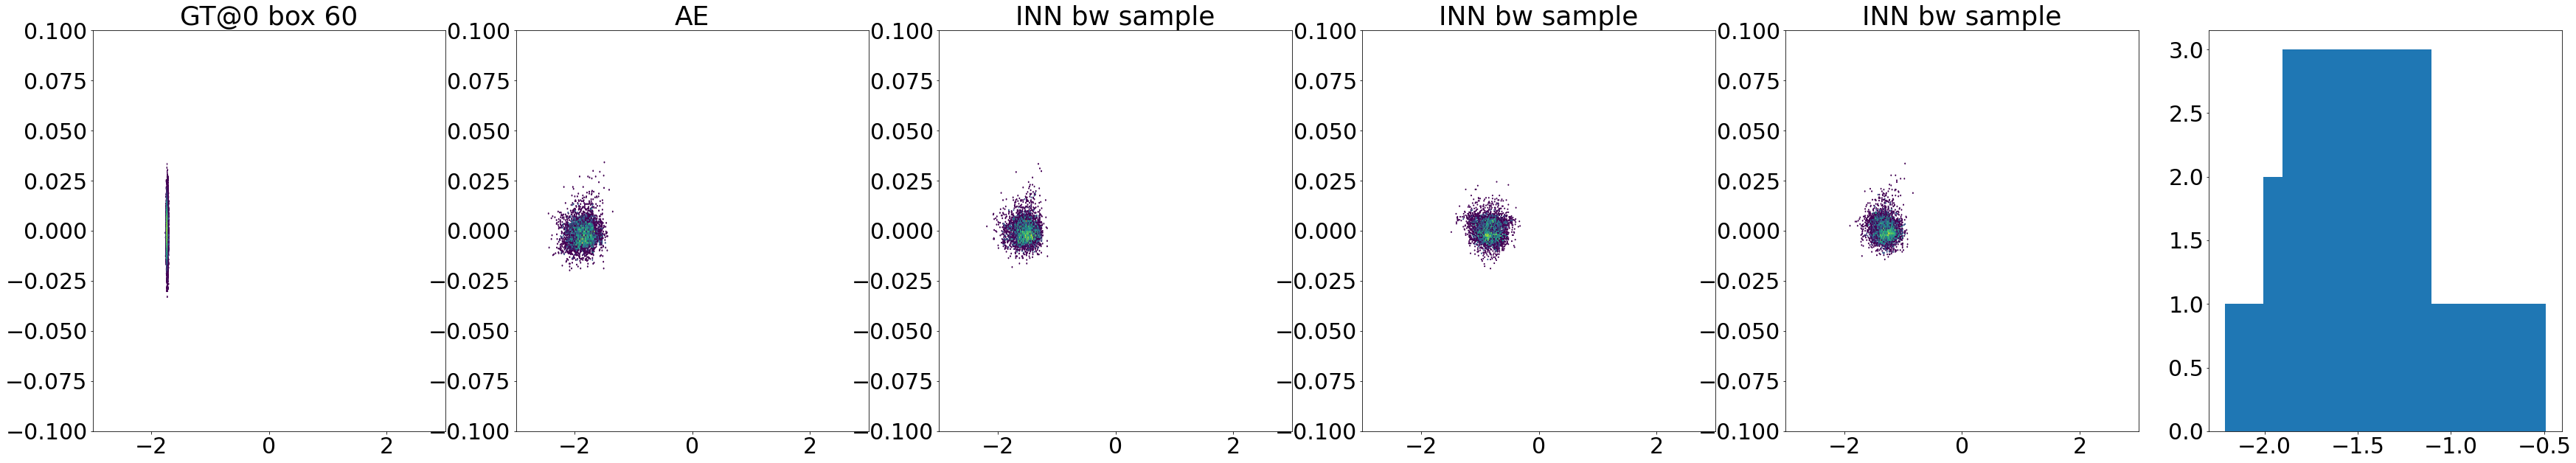

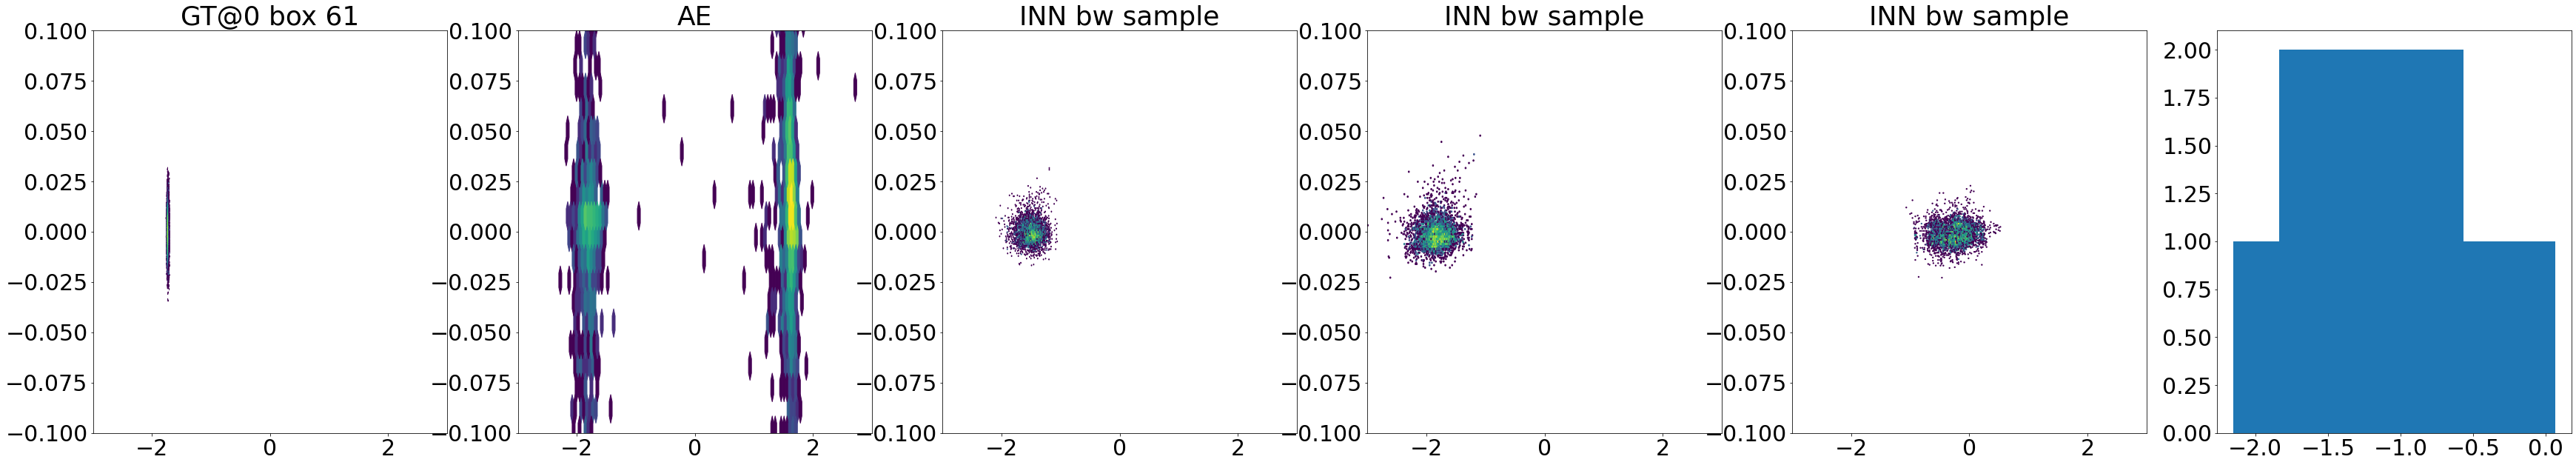

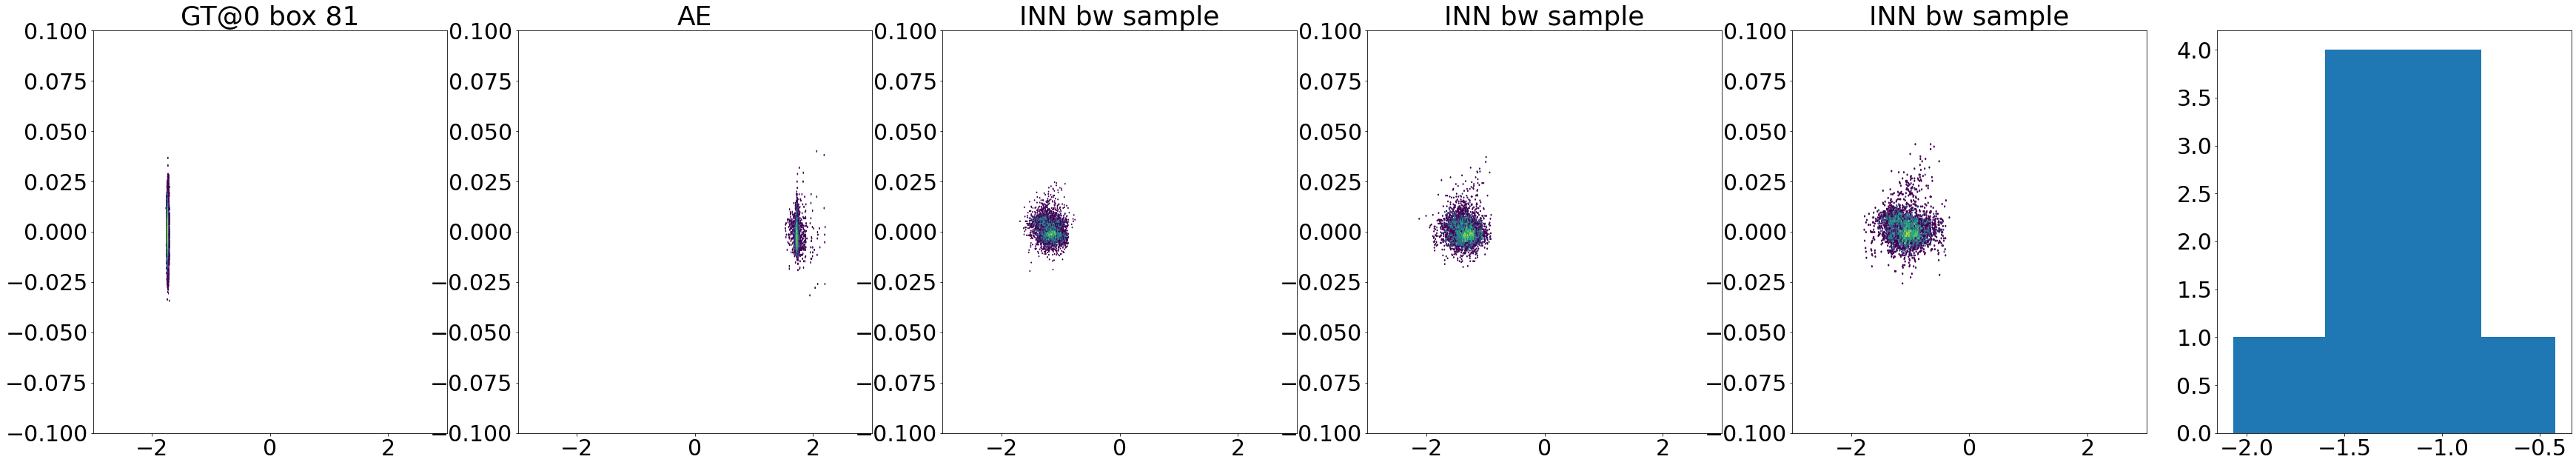

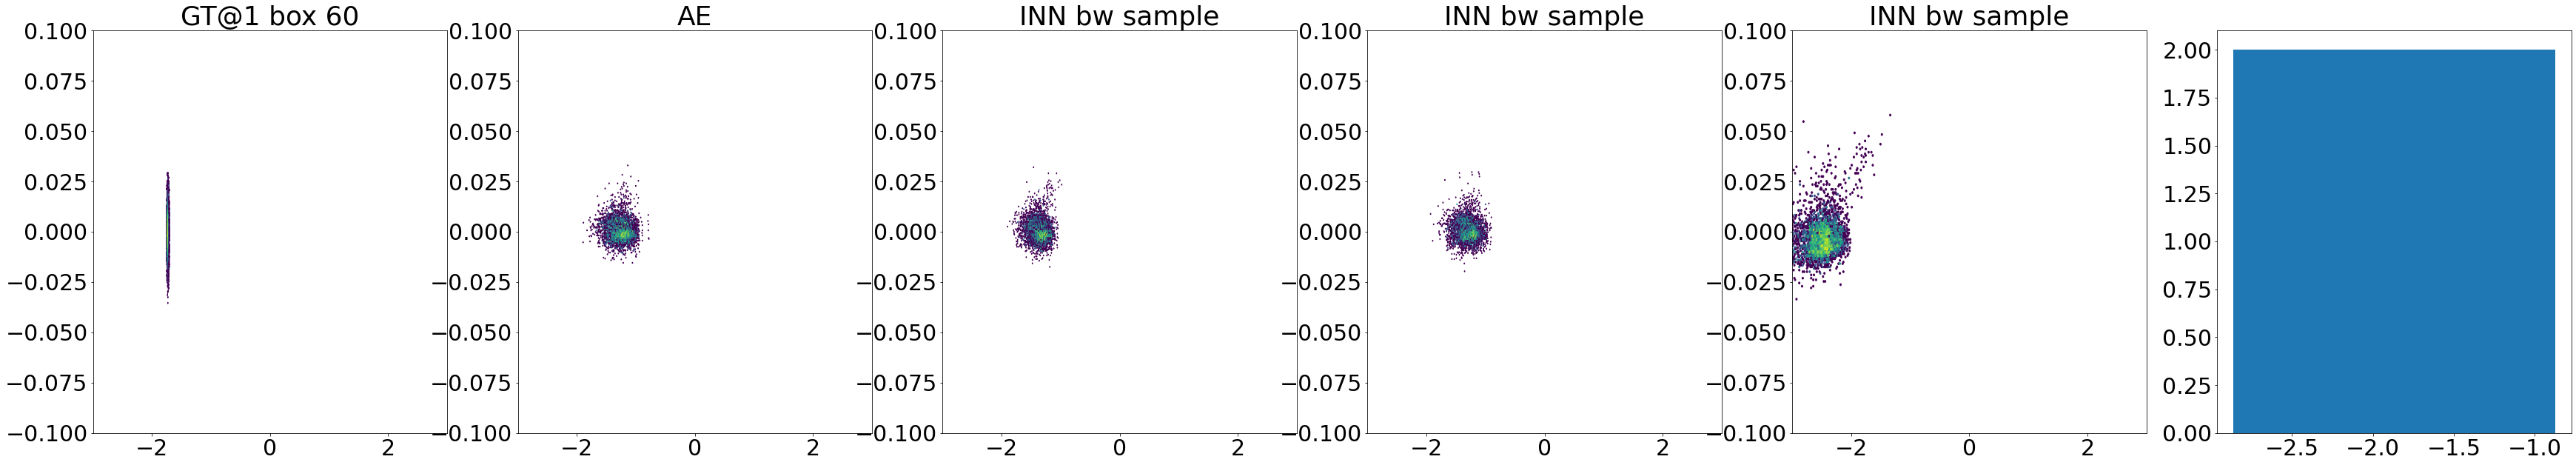

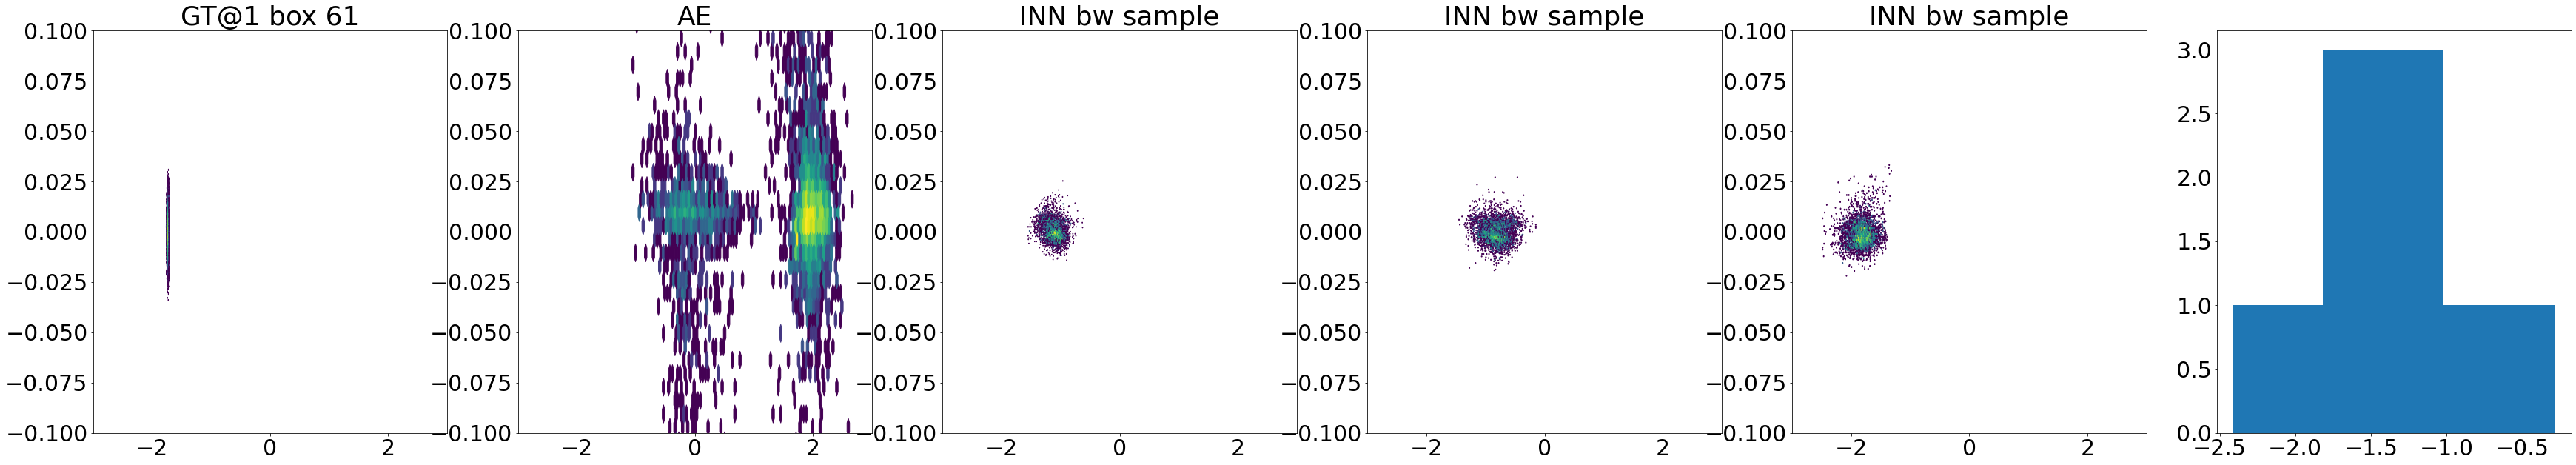

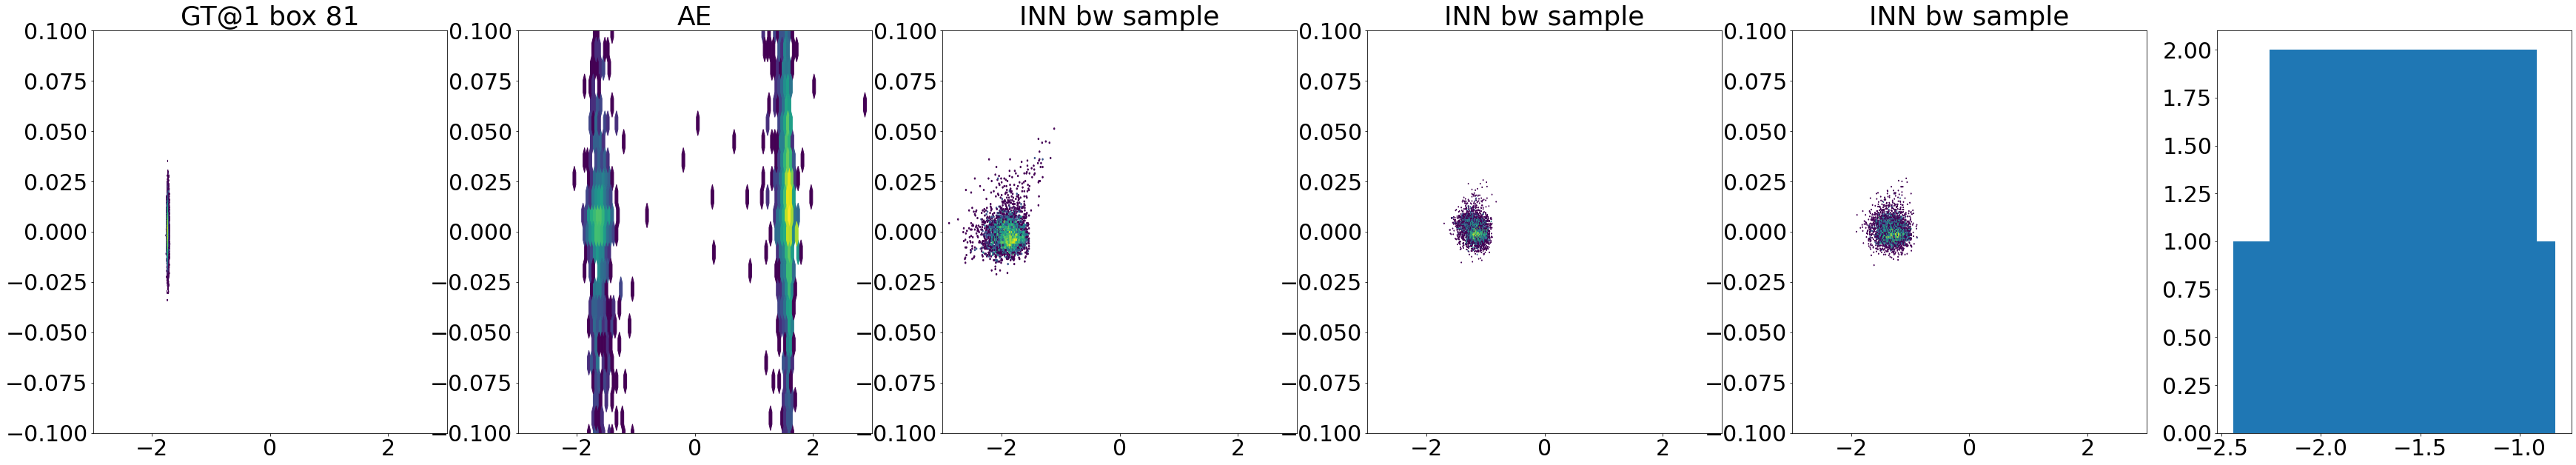

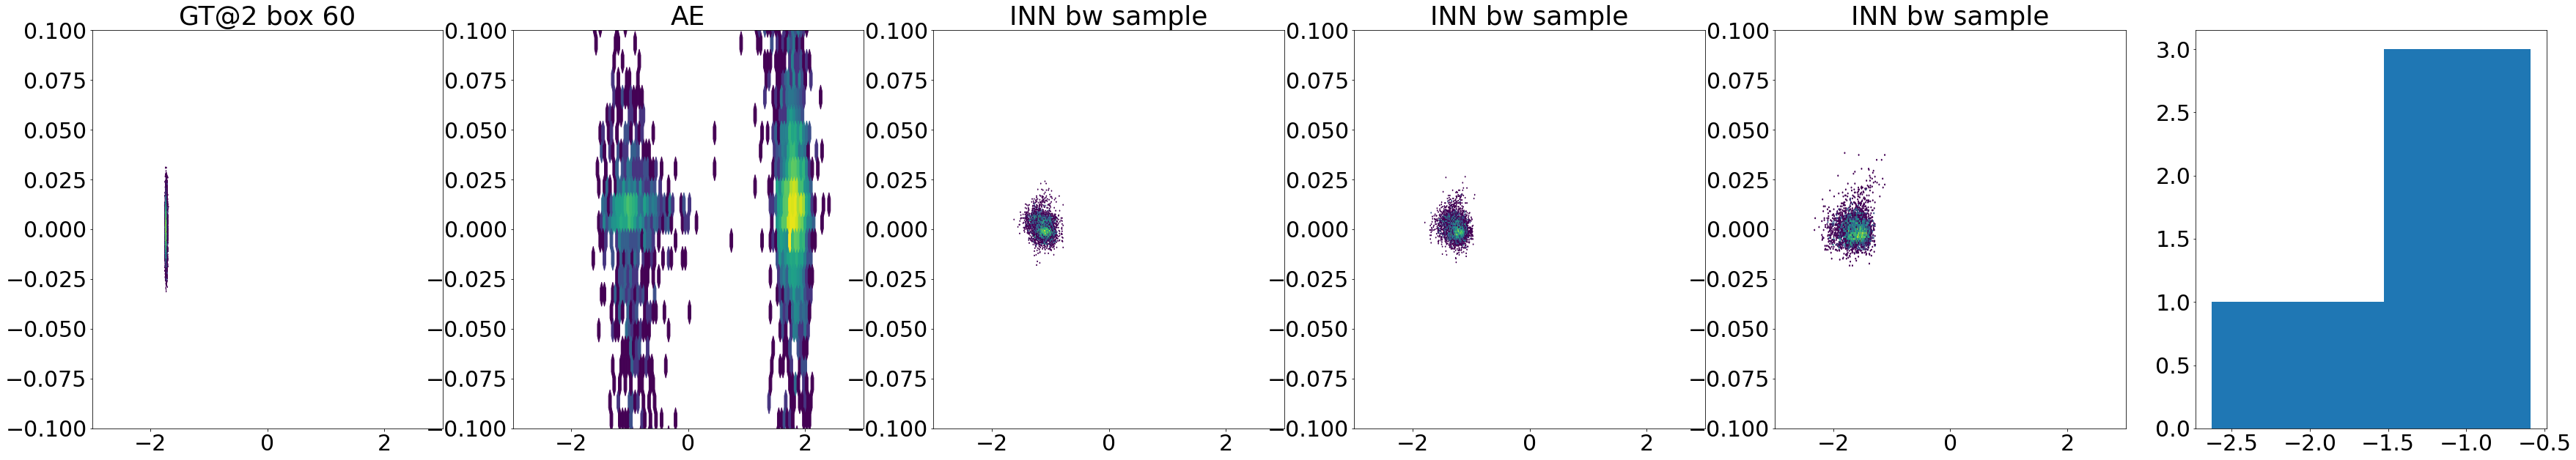

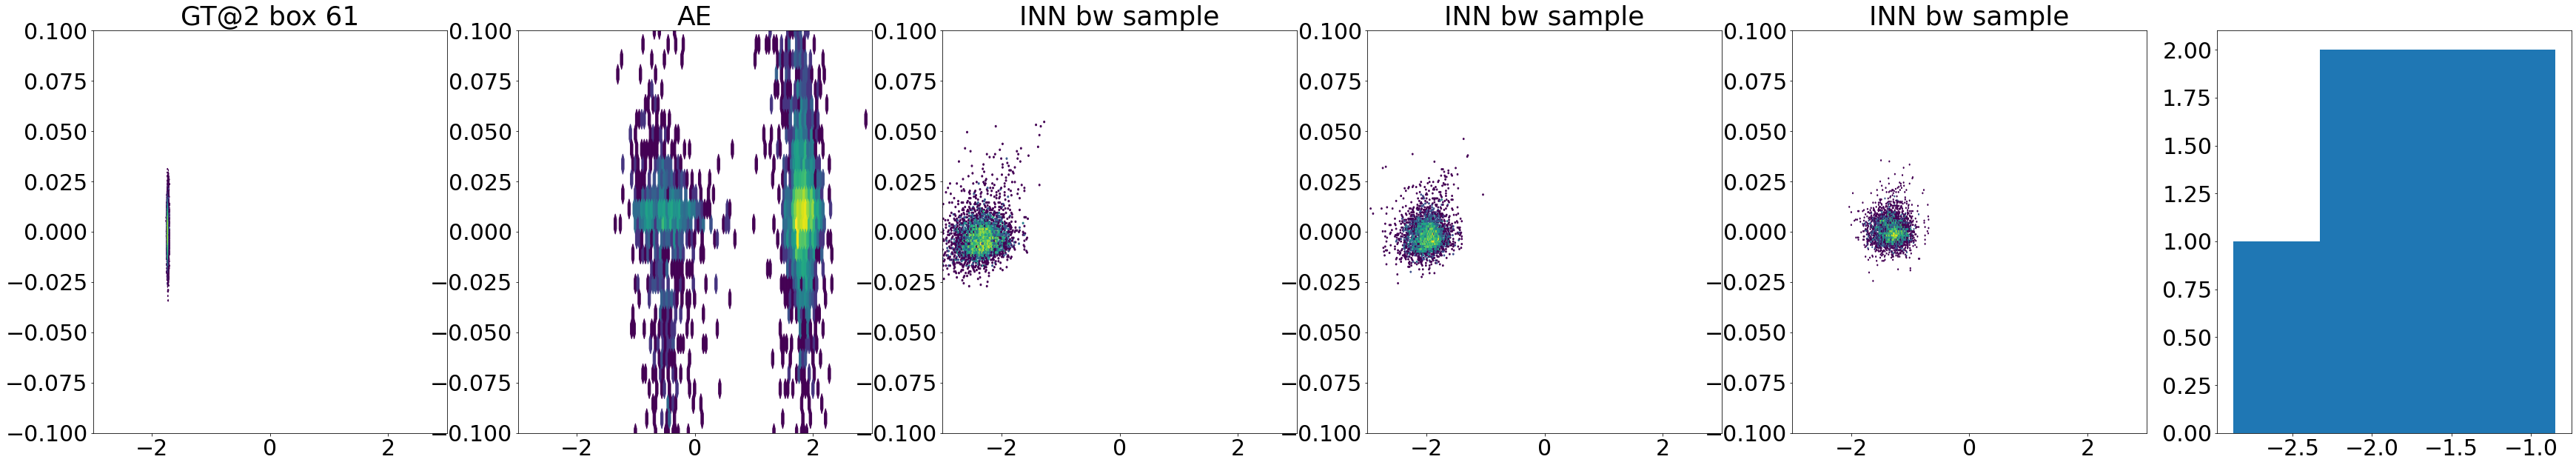

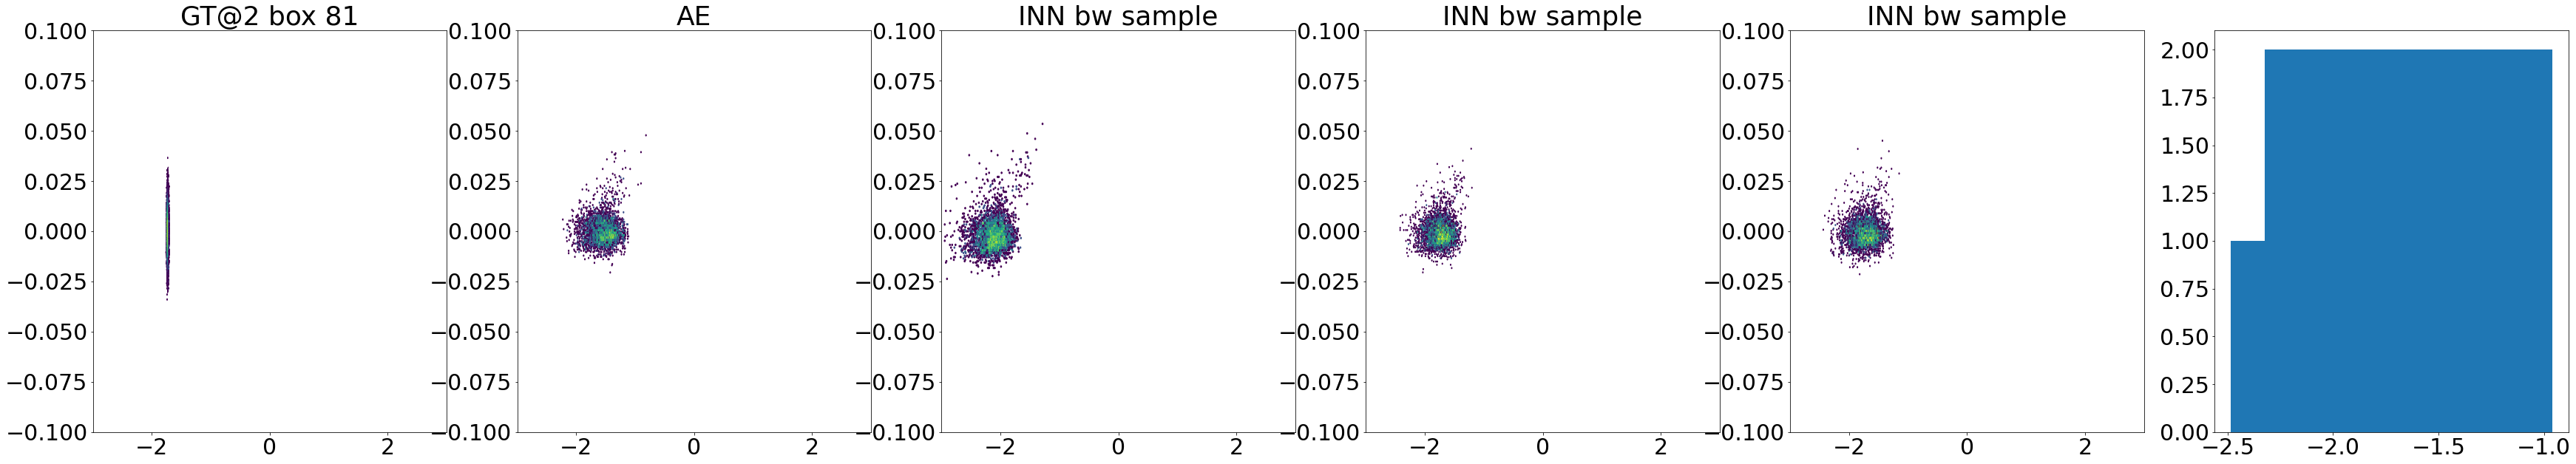

In [46]:
part = plot(boxList = [60,61,81], xlim=(-3,3), ylim=(-.1,.1), centerHistSamples=10)

(2, 2)


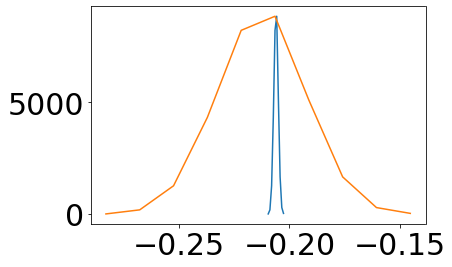

In [72]:
def center(bins):
    return ( bins[1:]+bins[:-1])/2

def momDenorm(x):
    return x * normalization_values["momentum_std"] + normalization_values["momentum_mean"]

i = -1
gthist, gtbins = np.histogram(momDenorm(part[i][2]))
gtx = center(gtbins)
genhist, genbins = np.histogram(momDenorm(part[i][1][2]))
print(part[i][0])
genx = center(genbins)
plt.plot(gtx, gthist)
plt.plot(genx, gthist)

pickPxGT = momDenorm(part[i][2])
pickPxGen = momDenorm(part[i][1][2])

In [42]:
def plotRad(boxList, xlim=(-3,3), ylim=(-.4,.4), centerHistSamples=0):
    plt.rcParams.update({'font.size': 30})
    
    results = []
    
    with torch.inference_mode():
        for it, tt in enumerate(data[-3:]):
            x = tt[0][boxList]
            y = tt[1][boxList]
            pc_pr = []
            lat_z_pred = []
            centerDist = []
            
            ae = model.base_network.forward(x.transpose(1,2).cuda())
            rad = model.inner_model.forward(ae[4])
            loss_IM, l_fit,l_latent,l_rev = model.inner_model.compute_losses(ae[4], y)
            
            rad = rad.detach().cpu().numpy()

            numPlotCol = rad.shape[0]
            fig, ax = plt.subplots(1, numPlotCol, figsize=(10*numPlotCol, 10), squeeze=True, sharey=True)
            for bi in range(len(boxList)):

                ax[bi].set_title("l_fit={:0.5} b={}".format(l_fit.item(), boxList[bi]))
                results.append([(it, bi), rad[bi, -512:], y[bi]])
                ax[bi].plot(rad[bi, -512:])
                ax[bi].plot(y[bi])
                    
            fig.show()
    
    return results

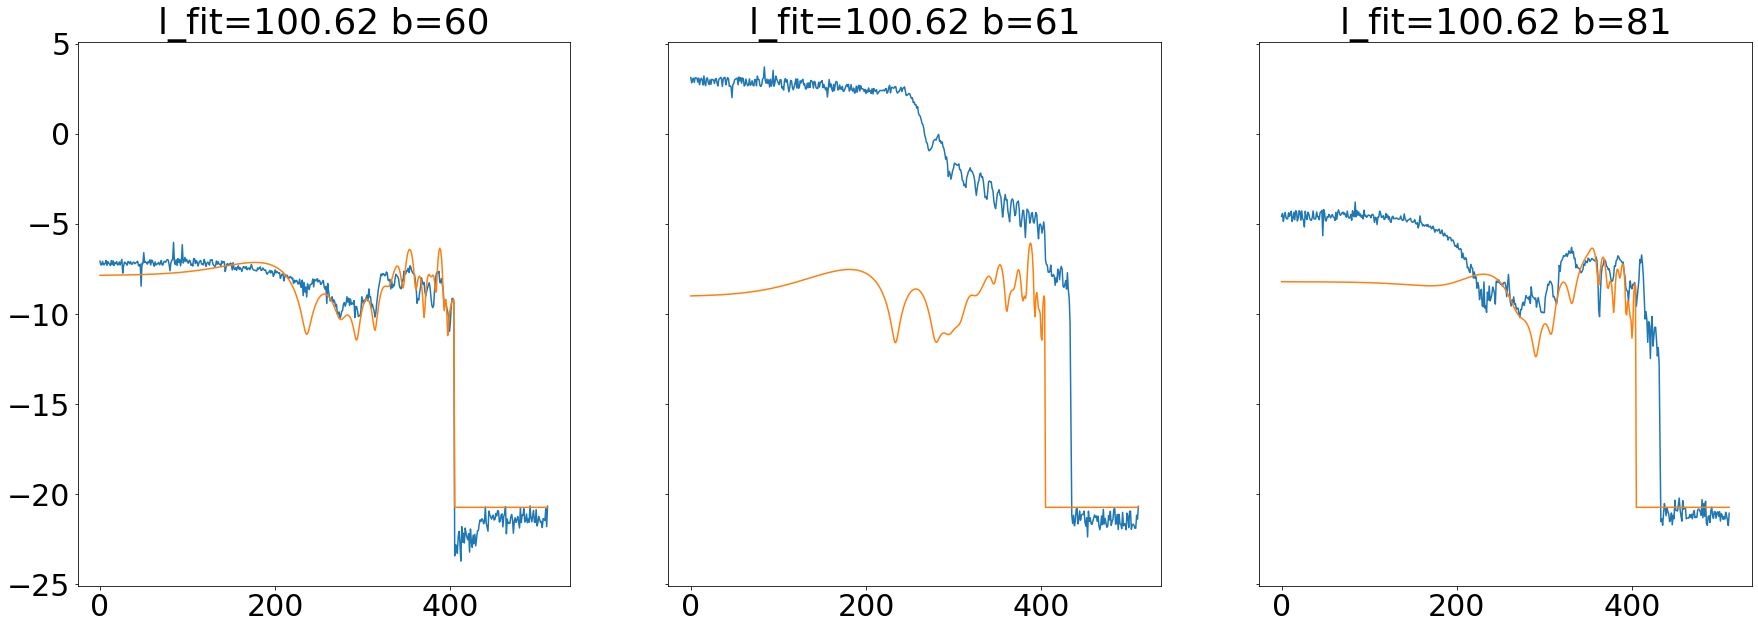

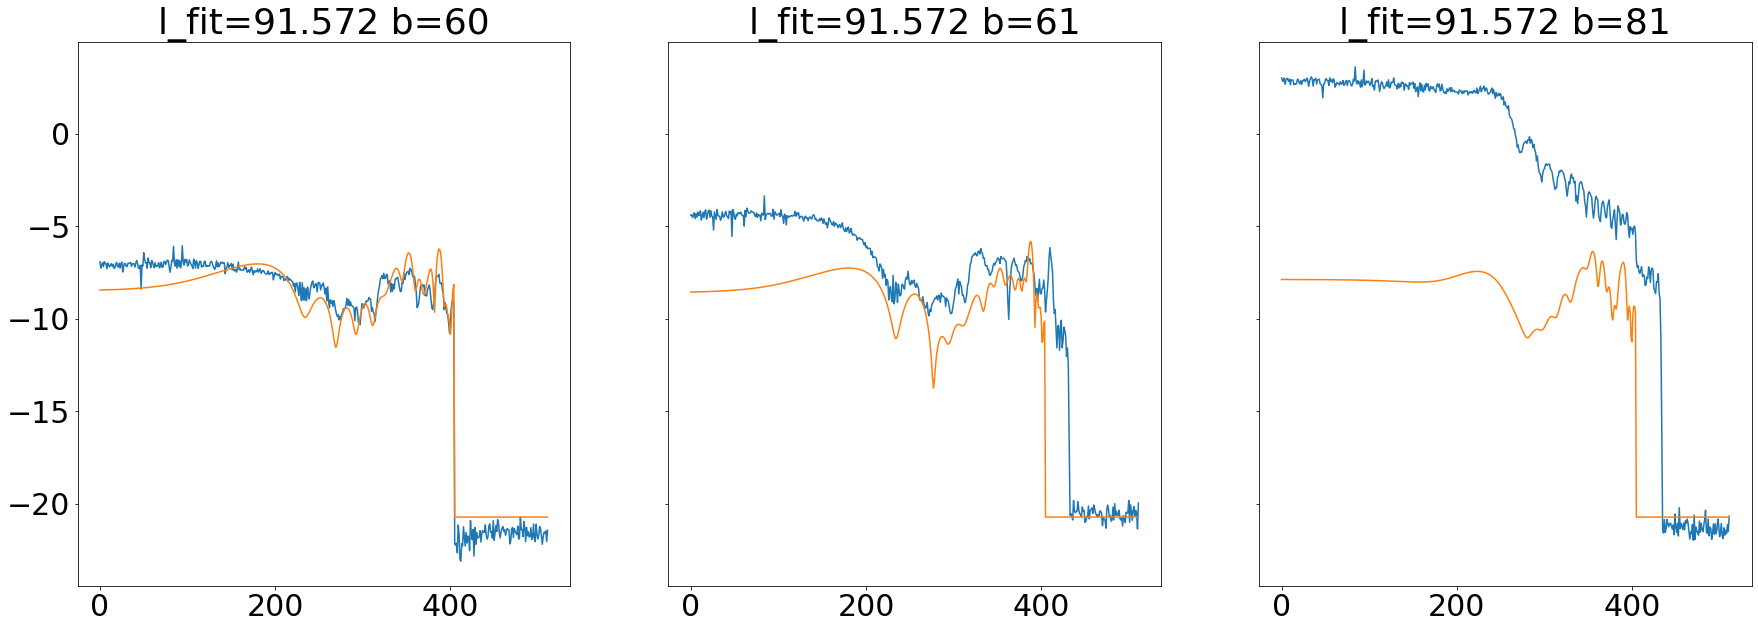

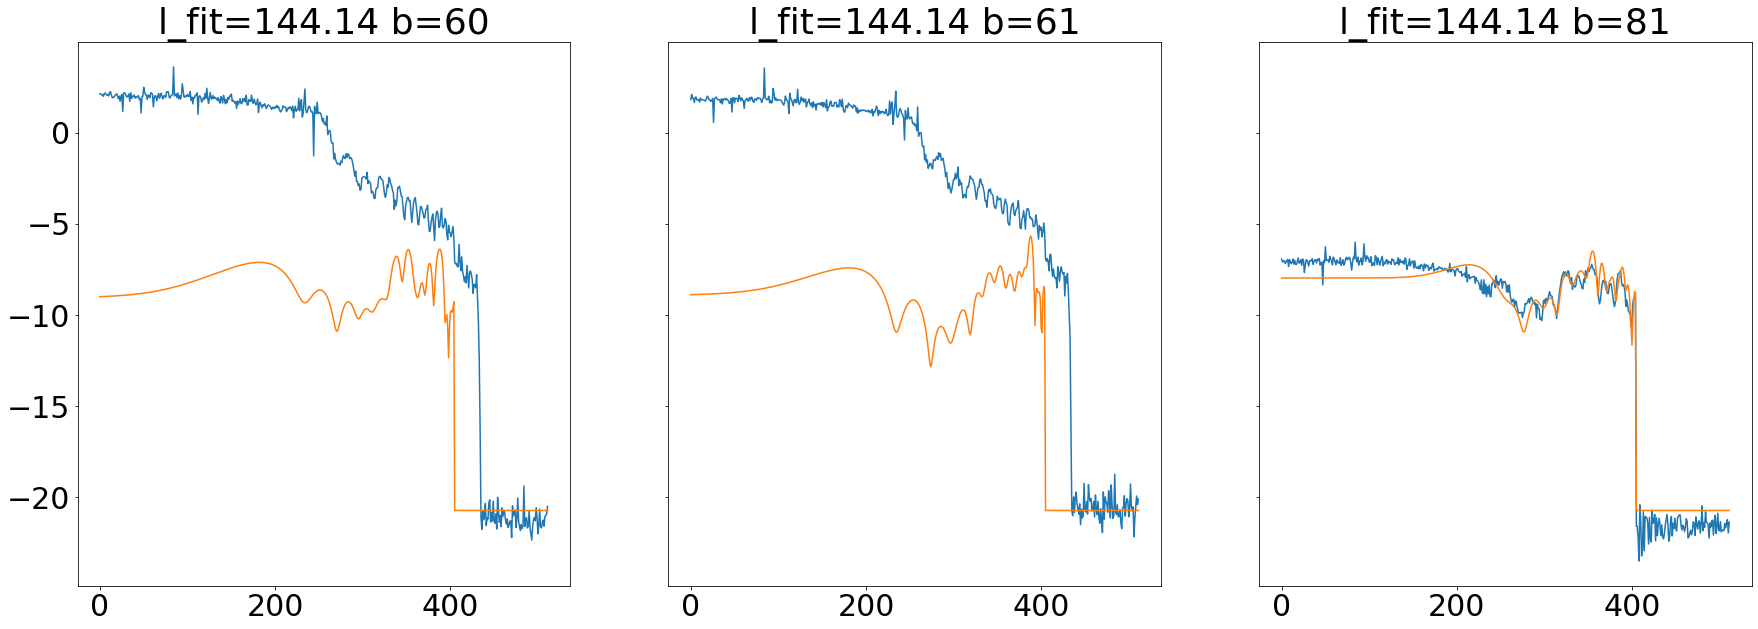

In [43]:
rad = plotRad(boxList = [60,61,81])

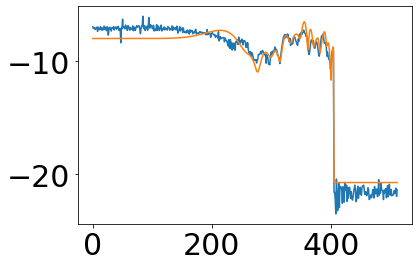

In [73]:
plt.plot(rad[-1][1])
plt.plot(rad[-1][2])

pickRadGT = rad[-1][1]
pickRadPred = rad[-1][1]

In [77]:
np.savez("picks.npz", pickPxGen=pickPxGen, pickPxGT=pickPxGT, pickRadPred=pickRadPred, pickRadGT=pickRadGT)

In [28]:
#plotRad(boxList = [1,2,5,6,9])

In [18]:
rad014fn = "/bigdata/hplsim/production/KHI_for_GB_MR/runs/014_KHI_007_noWindowFunction/simOutput/totalRad/e_radiation_{}.dat"
radFfn ="/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/{}-nodes_lr-0.001_min-tb-{}/simOutput/totalRad/e_radiation_{}.dat"

In [19]:
t = 900
tF = t
obs = 0

/tmp/ipykernel_15264/1153618546.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(rad014[obs]), linestyle="-", label="014")
/tmp/ipykernel_15264/1153618546.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(radF[obs]), linestyle=":", label="Frontier {} nodes".format(nn))


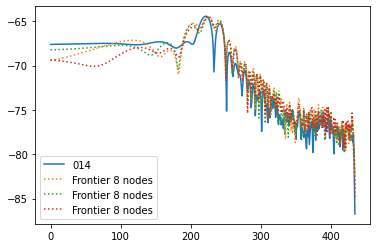

In [20]:
plt.rcParams.update({'font.size': 10})

fn = rad014fn.format(t)
rad014 = np.loadtxt(fn)
plt.plot(np.log(rad014[obs]), linestyle="-", label="014")
for nn in (8,):
    for tb in (4,8,16):
        fn = radFfn.format(nn, tb, tF)
        #print(fn)
        radF = np.loadtxt(fn)
        plt.plot(np.log(radF[obs]), linestyle=":", label="Frontier {} nodes".format(nn))
plt.legend()
plt.show()

In [116]:
r = np.load("/bigdata/hplsim/aipp/SC24_PIConGPU-Continual-Learning/03-30_learning-rate-scaling-with-ranks_chamfersdistance_fix-gpu-volume/96-nodes_lr-0.0001_min-tb-16/simOutput/streamedRadiation/ts_1.npy")

#r = np.load("/home/kelling/checkout/FWKT/InSituML/main/ModelHelpers/cINN/slurm-6924589/ts_1.npy")



(384, 1, 512)


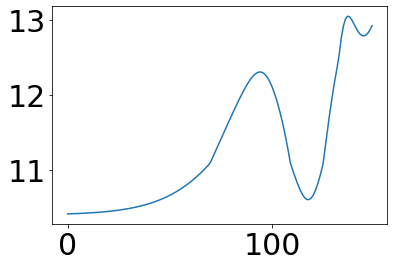

In [124]:
#plt.ylim((-1e2,0))
#plt.xlim((280,400))
print(r.shape)
plt.plot(np.log(-r[0,0,:150]))
#plt.plot(r[0,0,:150])